<a href="https://colab.research.google.com/github/Carlos1729/Transformers_Code/blob/main/HuggingFace/Batching_Inputs_Together.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

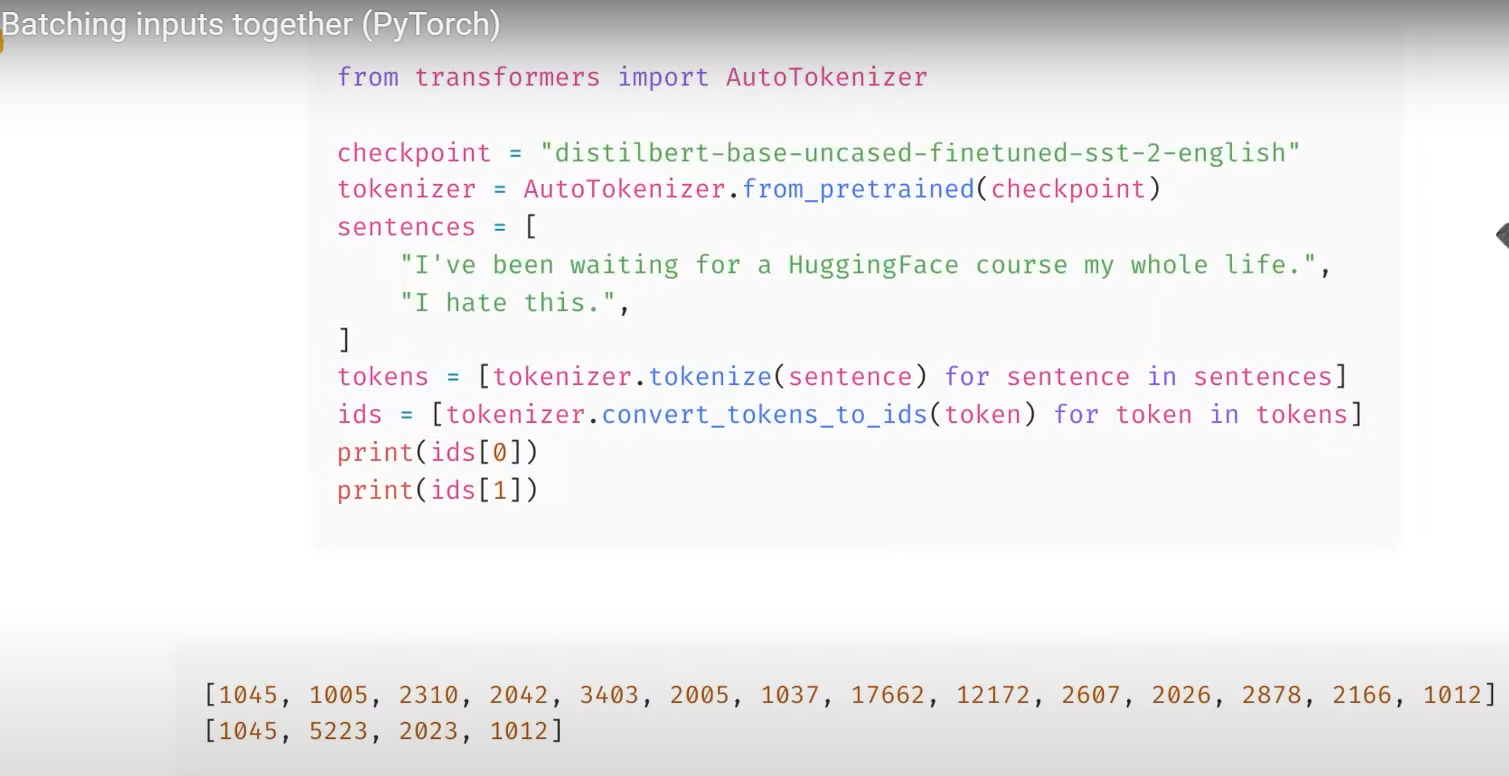

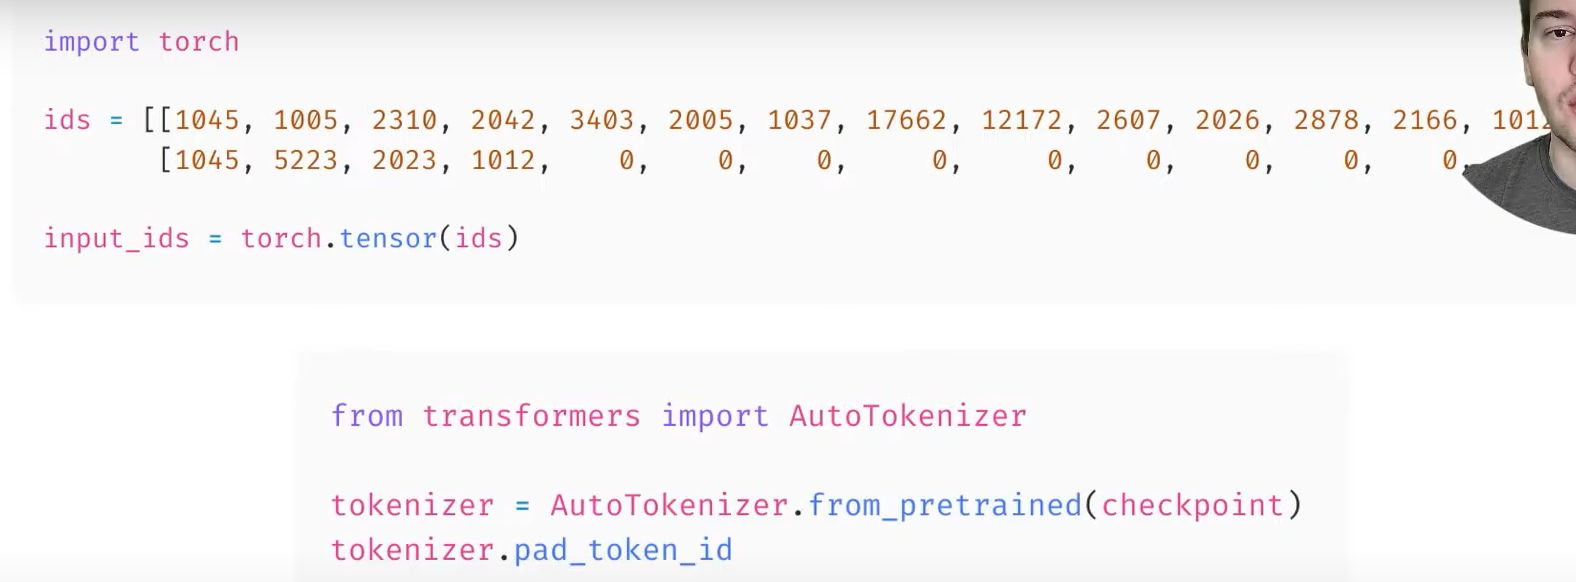

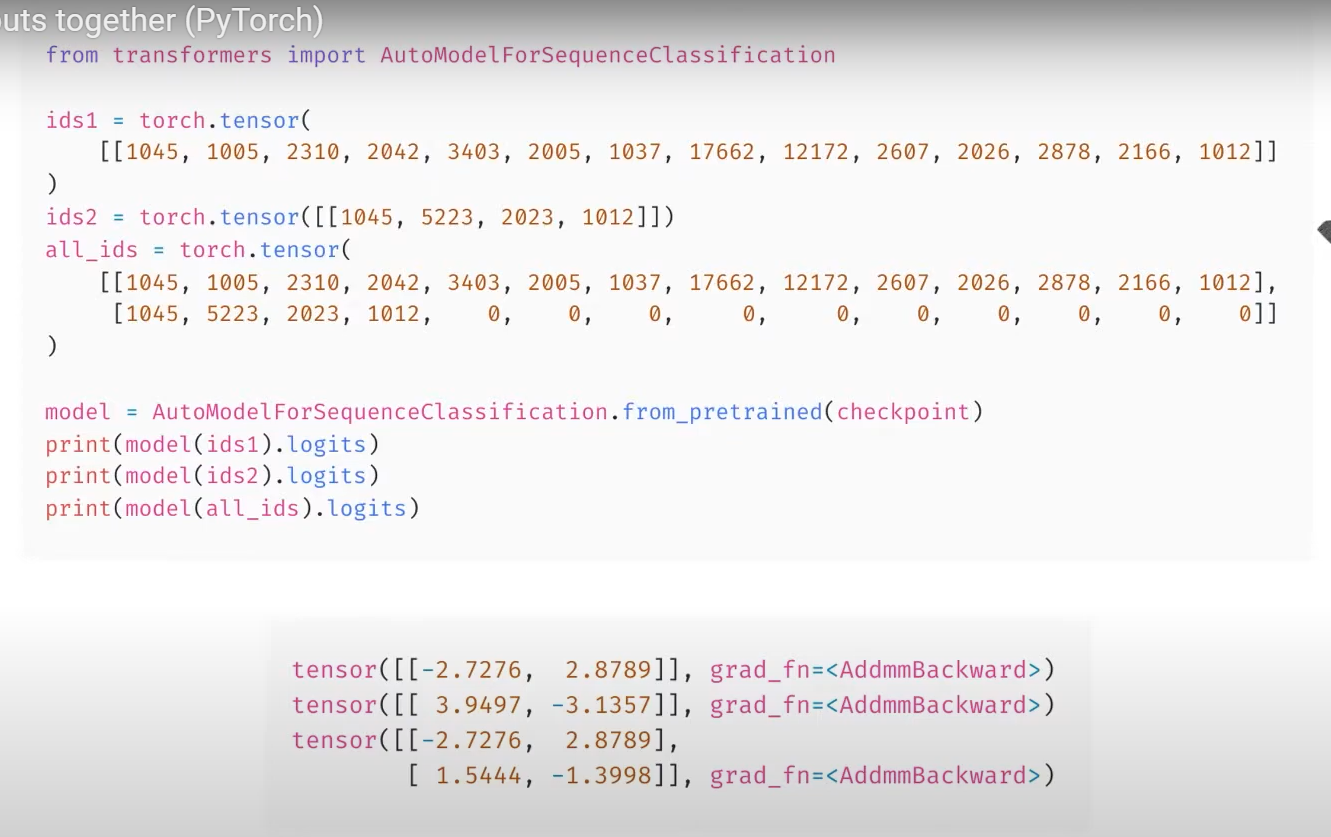

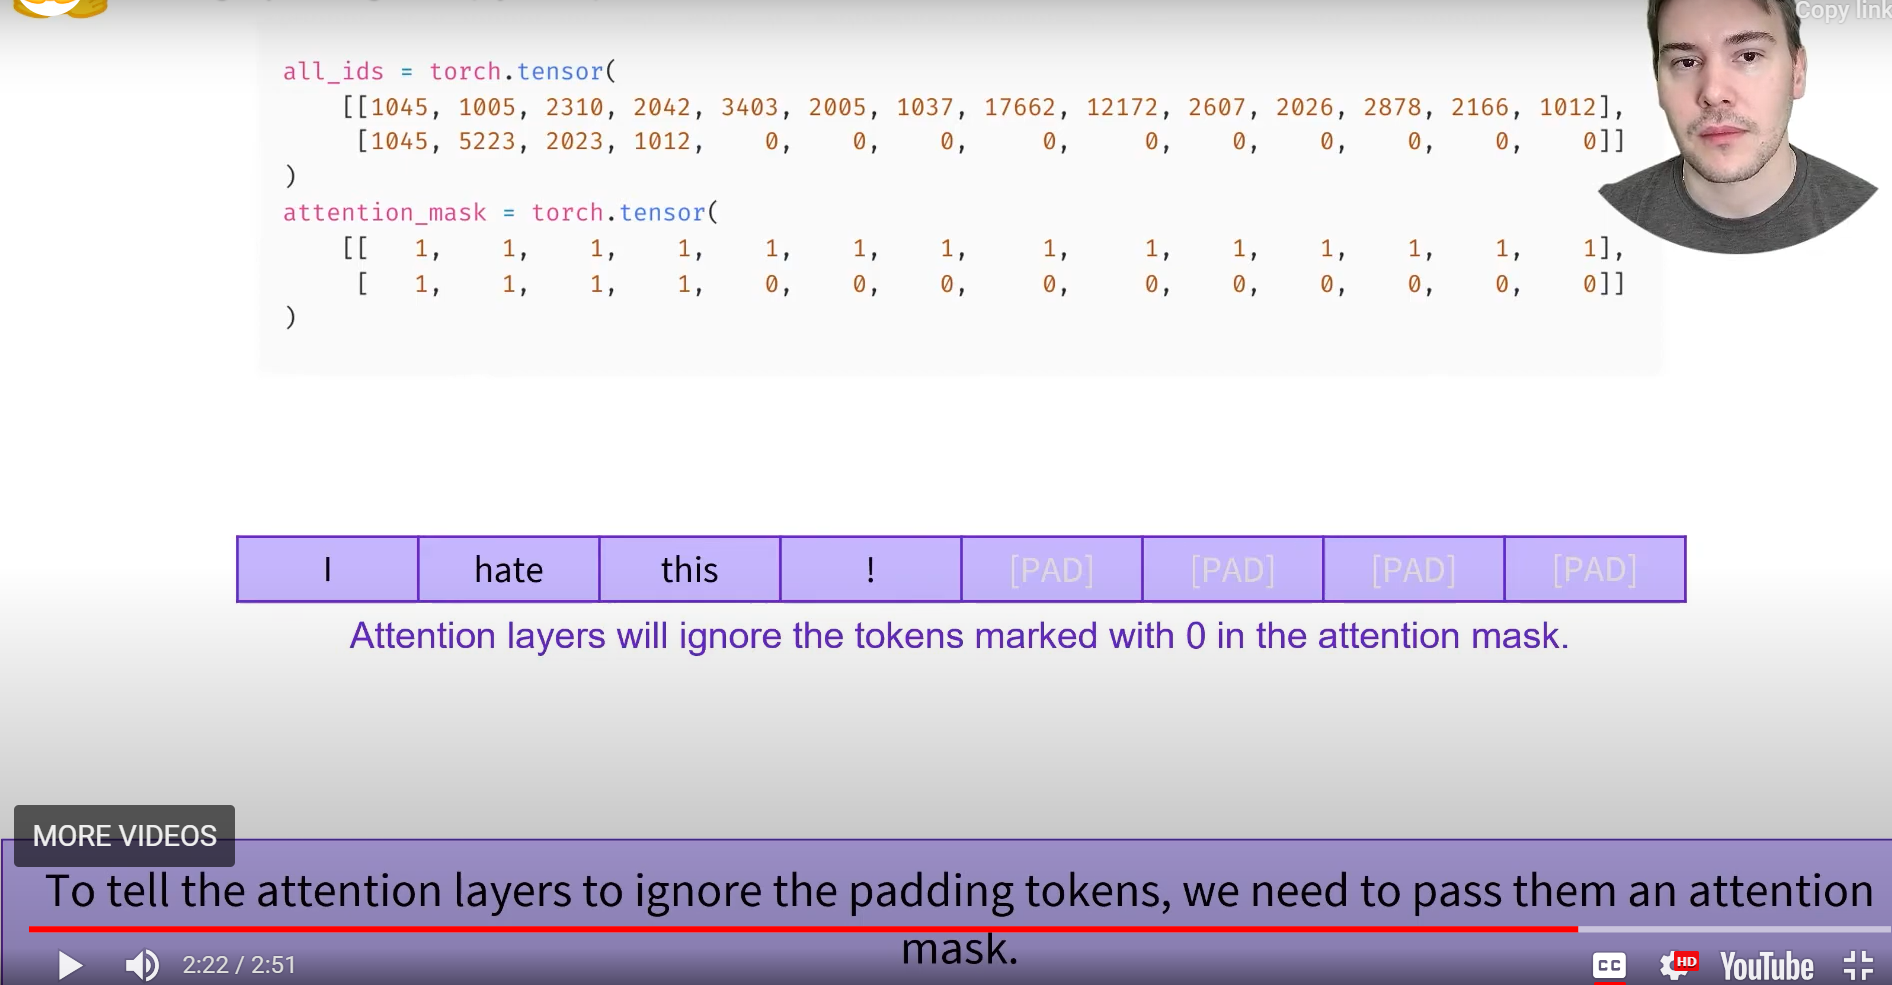

In [1]:
!pip install datasets evaluate transformers[sentencepiece]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.7 MB/s eta 0:00:00


In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

sequence = "I've been waiting for a HuggingFace course my whole life."

tokens = tokenizer.tokenize(sequence)
ids = tokenizer.convert_tokens_to_ids(tokens)
input_ids = torch.tensor(ids)
# This line will fail.
model(input_ids)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

IndexError: ignored

Oh no! Why did this fail? “We followed the steps from the pipeline in section 2.

The problem is that we sent a single sequence to the model, whereas 🤗 Transformers models expect multiple sentences by default. Here we tried to do everything the tokenizer did behind the scenes when we applied it to a sequence. But if you look closely, you’ll see that the tokenizer didn’t just convert the list of input IDs into a tensor, it added a dimension on top of it:

In [3]:
tokenized_inputs = tokenizer(sequence, return_tensors="pt")
print(tokenized_inputs["input_ids"])

tensor([[  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,
          2607,  2026,  2878,  2166,  1012,   102]])


In [4]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

sequence = "I've been waiting for a HuggingFace course my whole life."

tokens = tokenizer.tokenize(sequence)
ids = tokenizer.convert_tokens_to_ids(tokens)

input_ids = torch.tensor([ids])#here is the change
print("Input IDs:", input_ids)

output = model(input_ids)
print("Logits:", output.logits)

Input IDs: tensor([[ 1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,  2607,
          2026,  2878,  2166,  1012]])
Logits: tensor([[-2.7276,  2.8789]], grad_fn=<AddmmBackward0>)


When you’re trying to batch together two (or more) sentences, they might be of different lengths. If you’ve ever worked with tensors before, you know that they need to be of rectangular shape, so you won’t be able to convert the list of input IDs into a tensor directly. To work around this problem, we usually pad the inputs.

In [5]:
batched_ids = [
    [200, 200, 200],
    [200, 200]
]

In [6]:
# . Padding makes sure all our sentences have the same length by adding a special word called the padding token to the sentences with fewer values.
# For example, if you have 10 sentences with 10 words and 1 sentence with 20 words, padding will ensure all the sentences have 20 words

In [7]:
padding_id = 100

batched_ids = [
    [200, 200, 200],
    [200, 200, padding_id],
]

In [8]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

sequence1_ids = [[200, 200, 200]]
sequence2_ids = [[200, 200]]
batched_ids = [
    [200, 200, 200],
    [200, 200, tokenizer.pad_token_id],
]

print(model(torch.tensor(sequence1_ids)).logits)
print(model(torch.tensor(sequence2_ids)).logits)
print(model(torch.tensor(batched_ids)).logits)

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


tensor([[ 1.5694, -1.3895]], grad_fn=<AddmmBackward0>)
tensor([[ 0.5803, -0.4125]], grad_fn=<AddmmBackward0>)
tensor([[ 1.5694, -1.3895],
        [ 1.3374, -1.2163]], grad_fn=<AddmmBackward0>)


There’s something wrong with the logits in our batched predictions: the second row should be the same as the logits for the second sentence, but we’ve got completely different values!

This is because the key feature of Transformer models is attention layers that contextualize each token. These will take into account the padding tokens since they attend to all of the tokens of a sequence.

**Attention masks are tensors with the exact same shape as the input IDs tensor, filled with 0s and 1s: 1s indicate the corresponding tokens should be attended to, and 0s indicate the corresponding tokens should not be attended to (i.e., they should be ignored by the attention layers of the model).**

In [9]:
batched_ids = [
    [200, 200, 200],
    [200, 200, tokenizer.pad_token_id],
]

attention_mask = [
    [1, 1, 1],
    [1, 1, 0],
]

outputs = model(torch.tensor(batched_ids), attention_mask=torch.tensor(attention_mask))
print(outputs.logits)

tensor([[ 1.5694, -1.3895],
        [ 0.5803, -0.4125]], grad_fn=<AddmmBackward0>)
